<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/kep.png" height=75 width=75>
*This notebook uses routines from [PyKE](http://github.com/keplerGO/PyKE/) which is documented [here](http://pyke.keplerscience.org/). You can find these notebooks on [GitHub](https://github.com/christinahedges/k2torials)*

<!--NAVIGATION-->
< [Limb Darkening](01.05-Limb-Darkening.ipynb) | [Contents](index.ipynb) | [Which Flux to Use](02.03-Contaminants-And-Apertures.ipynb) >

# Basic Transit Models

Now we have a folded light curve we can fit a transit model to it. There are several packages to do this, based on several models implementations. I will go through a basic example of how to 1) create a transit model using existing packages 2) fit that transit model with scipy. 

Transit model implementations:
* BATMAN
* PyTransit
* KTransit




Let's load the data that we're working with again. In the last notebook we already folded and found the period of the planet.

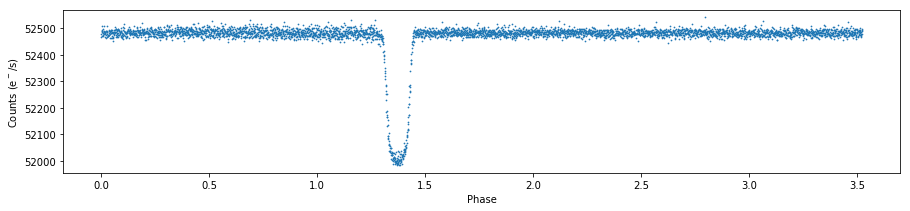

In [71]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
h = fits.open('data/kplr006922244-2010078095331_llc.fits')
h[1].data.names
t,flux,err=h[1].data['TIME'],h[1].data['PDCSAP_FLUX'],h[1].data['PDCSAP_FLUX_ERR']
t,flux,err=t[np.isfinite(flux)],flux[np.isfinite(flux)],err[np.isfinite(err)]

per=3.52233911024
phase = t  % per

plt.figure(figsize=(15,3))
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')

Now that we have limb darkening parameters we can build a transit model. In this case we're going to use [BATMAN](https://astro.uchicago.edu/~kreidberg/batman/installation.html) and [PyTransit](https://github.com/hpparvi/PyTransit). These packages are fairly easy to install and use and employs a Mandol and Agol (2002) model for transits. You can read more about transit models [here](transitmodels).

Firstly we will need to initialise our transit model. We will need the basic transit parameters to do this. 

We have already found the period in a previous notebook. We can find the transit center in this case quite easily by looking for the minimum of the smoothed, folded transit. This is shown below.

Transit Mid Point:	 1.37025243313 days


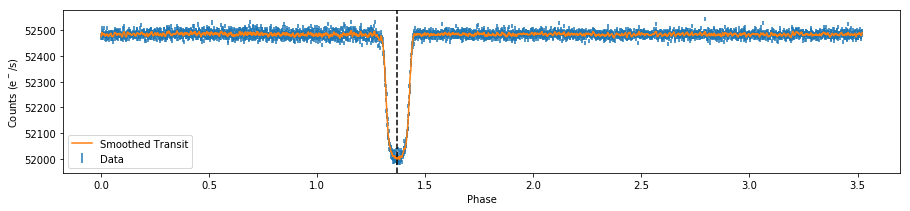

In [95]:
#Plot the data as above
plt.figure(figsize=(15,3))
plt.errorbar(phase,flux,err,ls='',label='Data')
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')

#Use a savgol filter to smooth the data, ordered by phase
from scipy.signal import savgol_filter
smooth=savgol_filter(flux[np.argsort(phase)],15,3)
plt.plot(np.sort(phase),smooth,c='C1',label='Smoothed Transit')

#Find the minimimum
t0=np.sort(phase)[np.argmin(smooth)]
plt.axvline(t0,c='black',ls='--')
plt.legend()

print('Transit Mid Point:\t',t0,'days')

Finally we can set up the parameters for the planet itself. In *BATMAN* these parameters are $a/R_*$, $R_P/R_*$ and $i$:

* $a/R_*$ : The ratio of the orbital separation of the planet to the radius of the host star
* $R_P/R_*$ : The ratio of the planet radius to the host star radius
* $i$ : Inclination of the planets.


These are common parameters required for a transit model fit. For this planet we can obtain these parameters using NExSci, as we did a few notebooks ago.

In [125]:
from PyAstronomy import pyasl
import astropy.units as u
nexa = pyasl.NasaExoplanetArchive()
planet=nexa.selectByPlanetName('kepler-8 b')


#Inclination
i=planet['pl_orbincl']

#Planet radius. Note we add the unit 'jupiter radius' 
R_p=planet['pl_radj']*u.jupiterRad

#Star radius. We add the unit 'solar radius' and then convert to jupiter radii
R_st=(planet['st_rad']*u.solRad).to(u.jupiterRad)

#Planet orbital distance in AU. We convert this to jupiter radii too.
d=(planet['pl_orbsmax']*u.AU).to(u.jupiterRad)


Now we can add these parameters into our models. Both BATMAN and PyTransit are shown below. More information on how to set them up can be found in their docs.

## BATMAN

In [171]:
import batman
params = batman.TransitParams()       #object to store transit parameters
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5230, 0.1218]           #limb darkening coefficients
params.per = per                      #orbital period
params.t0 = t0
params.inc = i
params.rp = (R_p/R_st).value
params.a = (d/R_st).value

m = batman.TransitModel(params, phase)
batman_lc=m.light_curve(params)*np.median(flux)

## PyTransit

PyTransit takes the following parameters in order.

* $R_P/R_*$
* Transit Mid Point
* Period
* $a/R_*$
* Inclination
* Eccentricity
* Argument of Periastron

In [172]:
from pytransit import MandelAgol
from math import pi
m = MandelAgol()


k, t0, p, a, inc, e, w = (R_p/R_st).value, t0, per, (d/R_st).value , (i*u.deg).to(u.rad).value, 0., 0.5*pi

pytransit_lc = MandelAgol().evaluate(phase, k, [0.5230, 0.1218], t0, p, a, inc, e, w)*np.nanmedian(flux)

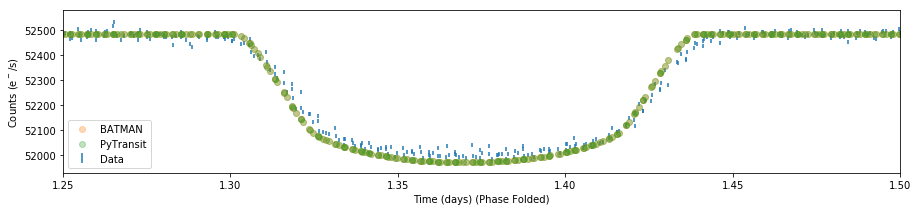

In [173]:
#Plot folded light curve with model.
plt.figure(figsize=(15,3))
plt.errorbar(phase,flux,err,ls='',zorder=-1,label='Data')
plt.scatter(phase,batman_lc,zorder=1,c='C1',alpha=0.3,label='BATMAN')
plt.scatter(phase,pytransit_lc,zorder=2,c='C2',alpha=0.3,label='PyTransit')
plt.legend()
plt.xlim(1.25,1.5)
plt.xlabel('Time (days) (Phase Folded)')
plt.ylabel('Counts (e$^-$/s)')

In the next notebook we will look at how to fit these parameters rather than relying on NExSci.

<!--NAVIGATION-->
< [Limb Darkening](01.05-Limb-Darkening.ipynb) | [Contents](index.ipynb) | [Which Flux to Use](02.03-Contaminants-And-Apertures.ipynb) >